# Demonstration: Memory-efficient Learned Design (MELD)

author: Michael Kellman

date: 16 April 2019

## System Information

Imaging Model: 

\begin{align}
    \mathbf{y} = \mathbf{F}^H \mathbf{H} \mathbf{F} \mathbf{x} + \mathbf{n}
\end{align}

Inverse Model:

\begin{align}
     \mathbf{x}^{\star} = \arg\underset{\mathbf{x}}{\min} \|\mathbf{F}^H \mathbf{H} \mathbf{F} \mathbf{x} - \mathbf{y}\|^2_2 + \lambda \left( \|\mathbf{W}\mathbf{x}\|_1 + \beta \|\mathbf{W}\mathbf{x}\|_2^2 \right)
\end{align}

In [19]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

# import modules
import numpy as np
from skimage import data
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.autograd as ag
import time

# import library dependencies
import sys
sys.path.append('./utilities/')
sys.path.append('./models/')
sys.path.append('./meld/')
from pytorch_complex import *
from utility import *
from deconv import *
from pytorch_proximal import *
from meld import *

# set types
dtype = torch.float32
np_dtype = np.float32
eps = np.finfo(np_dtype).eps

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup Graphical Processing Unit

In [20]:
gpu_device = 0
torch.cuda.set_device(gpu_device)
device = torch.device("cuda:"+str(gpu_device) if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_properties(gpu_device)

_CudaDeviceProperties(name='TITAN Xp', major=6, minor=1, total_memory=12196MB, multi_processor_count=30)

## Setup problem

<IPython.core.display.Javascript object>


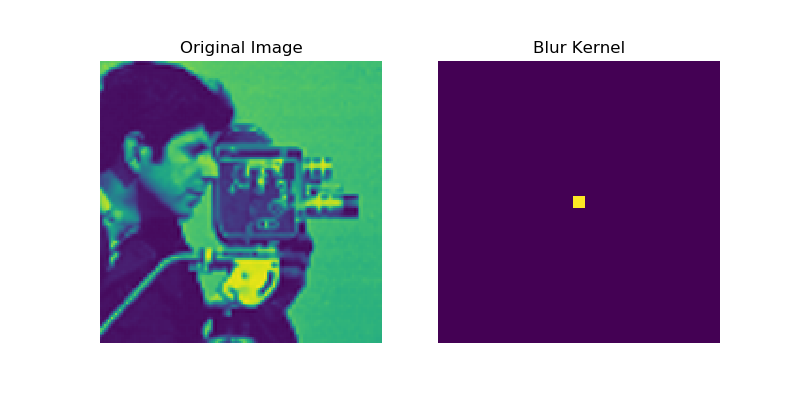

(-0.5, 149.5, 149.5, -0.5)

In [23]:
# setup image
img = data.camera().astype(np_dtype)
img = img[75:225,200:350]
Np = img.shape

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')

# setup blur kernel
from scipy.ndimage.filters import gaussian_filter
kernel = np.zeros(Np)
# kernel[Np[0]//2,Np[1]//2] = 1
# kernel = np.fft.fftshift(gaussian_filter(kernel, sigma=2)).astype(np_dtype)
kernel[Np[0]//2 - 3:Np[0]//2 + 3, Np[1]//2 - 3:Np[1]//2 + 3] = 1
kernel = np.fft.fftshift(kernel).astype(np_dtype)
plt.subplot(122)
plt.imshow(np.fft.ifftshift(kernel))
plt.title('Blur Kernel')
plt.axis('off')



## Setup Reconstruction Network | Learning

In [41]:
# gradient model
img_t = torch.from_numpy(img).to(device)
kernel_t = torch.from_numpy(kernel).to(device)
alpha_t = torch.tensor([5e-2],device=device).type(dtype)
grad = Deblur(Np, img_t, kernel_t, alpha_t, T=8, noise_level=0, device=device).to(device)

# proximal model (wavelet soft thresholding)
thr = torch.tensor([1e-3],device=device).type(dtype)
alpha = torch.tensor([1e-6],device=device).type(dtype)
prox = WaveletSoftThr(Np,thr,alpha,testFlag=True,device=device)
prox.to(device)

# setup network
pgd_layer = PGD(grad,prox)
Nlayers = 500
network = genNetwork(pgd_layer,Nlayers)

# setup learning
x0 = torch.zeros_like(img_t)
gpu_memory_limit = 50 # MB
unrolled_model = unroll(network, x0, gpu_memory_limit, device)

Memory per iteration: 1.0 MB
Total memory: 500.0 MB
Requires memory-efficient learning!
Checkpointing every: 10


## Verify forward backward consistency

<IPython.core.display.Javascript object>


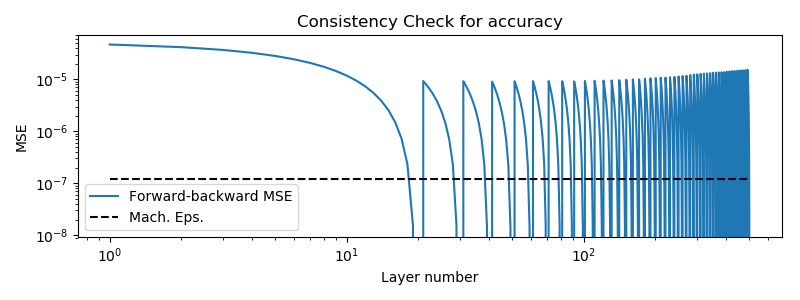

In [42]:
x0 = torch.zeros_like(img_t)
xtruth = img_t.to(device)
xN,loss,Xf,Xb = unrolled_model(x0, xtruth, interFlag=True, testFlag=True)

diff = torch.mean((Xf-Xb)**2,dim=(1,2)).cpu().numpy()
plt.figure(figsize=(8,3))
plt.loglog(np.linspace(1,Nlayers+1,Nlayers),diff,label='Forward-backward MSE')
plt.loglog([1,Nlayers],[eps,eps],'k--',label='Mach. Eps.')
plt.title('Consistency Check for accuracy')
plt.xlabel('Layer number')
plt.ylabel('MSE')
plt.legend()
plt.tight_layout()

<IPython.core.display.Javascript object>


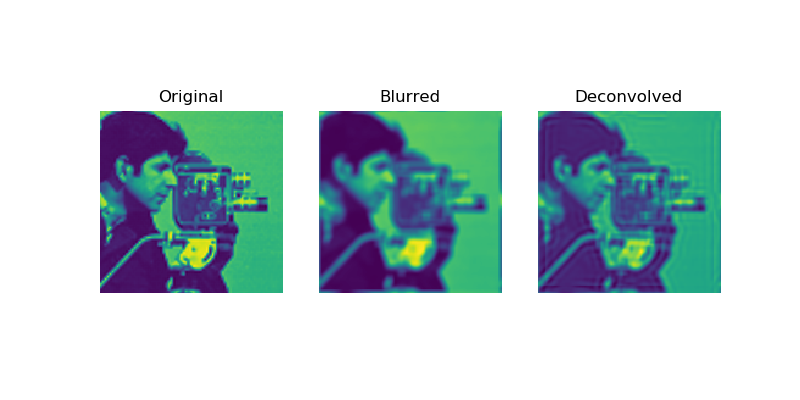

Text(0.5, 1.0, 'Deconvolved')

In [44]:
plt.figure(figsize=(8,4))
plt.subplot(131)
plt.imshow(img)
plt.axis('off')
plt.title('Original')
plt.subplot(132)
plt.imshow(grad.y.detach().cpu().numpy())
plt.axis('off')
plt.title('Blurred')
plt.subplot(133)
plt.imshow(xN.detach().cpu().numpy())
plt.axis('off')
plt.title('Deconvolved')

## Perform Learning

In [45]:
# gradient model
img_t = torch.from_numpy(img).to(device)
kernel_t = torch.from_numpy(kernel).to(device)
alpha_t = torch.tensor([5e-2],device=device).type(dtype)
grad = Deblur(Np, img_t, kernel_t, alpha_t, device=device).to(device)

# proximal model
thr = torch.tensor([1e-3],device=device).type(dtype)
alpha = torch.tensor([1e-6],device=device).type(dtype)
prox = WaveletSoftThr(Np,thr,alpha,testFlag=True,device=device)
prox.to(device)

# setup network
pgd_layer = PGD(grad,prox)
Nlayers = 500
network = genNetwork(pgd_layer,Nlayers)

# setup learning
unrolled_model = unroll(network, x0, gpu_memory_limit, device)



Memory per iteration: 1.0 MB
Total memory: 500.0 MB
Requires memory-efficient learning!
Checkpointing every: 10


In [46]:
# look at learnable parameters
print([p_ for p_ in network.parameters()])

[Parameter containing:
tensor([0.0500], device='cuda:0', requires_grad=True), Parameter containing:
tensor([0.0010], device='cuda:0', requires_grad=True)]


In [ ]:
# setup optimizer
learning_rate = 1e-3
learning_iteration = 200
learning_loss = torch.zeros(learning_iteration)
optim = torch.optim.Adam(network.parameters(),learning_rate)

# perform learning
for ll in range(learning_iteration):
    
    optim.zero_grad()
    
    xN,loss,Xf,Xb = unrolled_model(x0, xtruth, interFlag=False, testFlag=True)
    
    optim.step()
    
    # printing
    with torch.no_grad():
        learning_loss[ll] = loss.detach()
        print ('Iteration: %05d | Loss: %.5e' % (ll, learning_loss[ll]), '\r', end='')

In [ ]:
plt.figure(figsize=(8,4))
plt.subplot(131)
plt.imshow(img)
plt.axis('off')
plt.title('Original')
plt.subplot(132)
plt.imshow(grad.y.detach().cpu().numpy())
plt.axis('off')
plt.title('Blurred')
plt.subplot(133)
plt.imshow(xN.detach().cpu().numpy())
plt.axis('off')
plt.title('Deconvolved')

plt.figure(figsize=(8,4))
plt.loglog(learning_loss.numpy())

# look at learnable parameters
print([p_ for p_ in network.parameters()])